<div style="text-align: center;" >
<h1 style="margin-top: 0.2em; margin-bottom: 0.1em;">Assignment 3</h1>
</div>
<br>

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed. 

* [`transformers`](https://huggingface.co/) is a Python package for creating and working with transformers. [Here](https://huggingface.co/docs) is the documentation of `transformers`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`torch`](https://pytorch.org/) is a Python machine learning framework. We need this here for `transformers` since this package uses internally `torch`. [Here](https://pytorch.org/docs/stable/index.html) is the documentation of `torch`.

In [1]:
! pip install transformers
! pip install pandas
! pip install torch

You may need to restart the Kernel after installing the dependencies!

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [1]:
import pandas as pd
from transformers import pipeline
import numpy as np
import matplotlib.pyplot as plt

### Exercise 1

In the following exercise you will use the emotion classification model [LEIA](https://huggingface.co/LEIA/LEIA-base) to classify the emotion of the sentences in the [enISEAR dataset](https://www.romanklinger.de/data-sets/). You read more about the `LEIA-base` in the [documentation](https://huggingface.co/LEIA/LEIA-base) and learn about the implementation details from this [paper](https://arxiv.org/abs/2304.10973).

#### 1.1 LEIA introduction
* Load the `LEIA-base` model and tokenize either as a [pipeline](https://huggingface.co/docs/transformers/main_classes/pipelines), or you can load the model and the tokenizer [directly](https://huggingface.co/docs/transformers/autoclass_tutorial) and implement the classification steps by yourself. LEIA only accepts sentences with up to 128 tokens. Make sure that your tokenizer [truncates](https://huggingface.co/docs/transformers/pad_truncation) longer sentences to this lenght to avoid errors.
* What are the possible labels the model can predict?
* Input the sentence `Today is a great day.` to the model, and predict the emotion of the sentence.

In [2]:

# import pipeline
pipe_leia = pipeline('text-classification', model='LEIA/LEIA-base', 
                     tokenizer='LEIA/LEIA-base', truncation=True, max_length=128)

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [6]:
# print labels
pipe_leia.model.config.id2label

{0: 'Sadness', 1: 'Affection', 2: 'Fear', 3: 'Happiness', 4: 'Anger'}

In [7]:
# predict emotion of example sentence
sentence = 'Today is a great day.'
pipe_leia(sentence)

[{'label': 'Happiness', 'score': 0.7999403476715088}]

#### 1.2 enISEAR dataset
* Load the enISEAR dataset.
* What are the possible labels in the dataset? (the `Prior_Emotion` column stores the actual label)
* The last 7 columns store the labels given by the annotators. Create a new column `Annotator_Majority_Label`, which stores the emotion with the highest annotator score (i.e. the emotion the highest number of annotators chose for the given sentence).
* What percent of the sentences were correctly classified by the (majority vote of the) annotators?

In [8]:
df = pd.read_csv('enISEAR.tsv', sep='\t')

In [9]:
df.head(2)

,Sentence_id,Prior_Emotion,Sentence,Temporal_Distance,Intensity,Duration,Gender,City,Country,Worker_id,Time,Anger,Disgust,Fear,Guilt,Joy,Sadness,Shame
0,271,Fear,"I felt ... when my 2 year old broke her leg, a...",Y,Vi,Dom,Ml,Bristol,GBR,87,11/28/2018 00:58:52,0,0,0,1,0,3,1
1,597,Shame,I felt ... one Christmas as one of our patient...,Y,I,Dom,Fl,Dulwich,GBR,86,11/26/2018 06:52:02,1,0,0,4,0,0,0


In [10]:
# possible labels
df['Prior_Emotion'].unique().tolist()

['Fear', 'Shame', 'Guilt', 'Disgust', 'Sadness', 'Anger', 'Joy']

In [11]:
label_cols = df['Prior_Emotion'].unique().tolist()
df['Annotator_Majority_Label'] = df[label_cols].idxmax(axis=1)
df.head(2)

,Sentence_id,Prior_Emotion,Sentence,Temporal_Distance,Intensity,Duration,Gender,City,Country,Worker_id,Time,Anger,Disgust,Fear,Guilt,Joy,Sadness,Shame,Annotator_Majority_Label
0,271,Fear,"I felt ... when my 2 year old broke her leg, a...",Y,Vi,Dom,Ml,Bristol,GBR,87,11/28/2018 00:58:52,0,0,0,1,0,3,1,Sadness
1,597,Shame,I felt ... one Christmas as one of our patient...,Y,I,Dom,Fl,Dulwich,GBR,86,11/26/2018 06:52:02,1,0,0,4,0,0,0,Guilt


In [12]:
df['Annotator_Majority_Label'].unique().tolist()

['Sadness', 'Guilt', 'Anger', 'Disgust', 'Fear', 'Joy', 'Shame']

In [13]:
# calculate the share of correctly specified sentences
annot_accuracy = (df['Annotator_Majority_Label'] == df['Prior_Emotion']).sum() / len(df)
print('Percent of correctly classified sentences: \033[1m{:.2%}\033[0m'.format(annot_accuracy))

Percent of correctly classified sentences: 79.52%


#### 1.3 Classification
* Drop the rows from the enISEAR dataset, where the `Prior_Emotion` is not one of `Fear`, `Sadness`, `Anger` or `Joy`
* Use `Leia` to classify the emotion of each remaining sentence in the dataset, and add a column `Leia_Label` to store the predicted classes
* Now remove `I felt ... ` from the beginning of each sentence, and rerun the classfication. Store your results in a column named `Leia_Label_Clean`
* Where the model predicted `Happiness` or `Affection`, change the prediction to `Joy` to match the dataset's labels (for both columns -> `Leia_Label` and `Leia_Label_Clean`)

In [14]:
from tqdm.notebook import tqdm
tqdm.pandas()

In [15]:
# preprocessing
cols_to_drop = ['Disgust', 'Guilt', 'Shame']
df = df[[i for i in df.columns if i not in cols_to_drop]]
df = df.loc[~df['Prior_Emotion'].isin(cols_to_drop)]
df = df.reset_index(drop=True)
df

,Sentence_id,Prior_Emotion,Sentence,Temporal_Distance,Intensity,Duration,Gender,City,Country,Worker_id,Time,Anger,Fear,Joy,Sadness,Annotator_Majority_Label
0,271,Fear,"I felt ... when my 2 year old broke her leg, a...",Y,Vi,Dom,Ml,Bristol,GBR,87,11/28/2018 00:58:52,0,0,0,3,Sadness
1,509,Sadness,I felt ... when my Gran passed away.,Y,Vi,Dom,Fl,Stoke-on-trent,GBR,92,11/26/2018 09:23:38,0,0,0,5,Sadness
2,218,Fear,I felt ... when an aeroplane I was on hit a he...,Y,Vi,Sh,Ml,Prescot,GBR,63,11/24/2018 09:14:44,0,5,0,0,Fear
3,553,Sadness,I felt ... when my lover Pierre-Guillaume left...,M,Vi,Dom,Fl,NaN,GBR,105,11/28/2018 09:31:20,4,0,0,1,Anger
4,58,Anger,I felt ... when someone hit my wife's car and ...,W,Mi,H,Ml,Bristol,GBR,87,11/28/2018 00:53:03,5,0,0,0,Anger
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,536,Sadness,I felt ... when an impoverished family we know...,D,I,Dom,Fl,Ely,GBR,62,11/27/2018 19:10:33,1,0,0,3,Sadness
568,546,Sadness,I felt ... when a horse was killed in the Gran...,Y,Mi,Fm,Ml,Chelmsford,GBR,91,11/26/2018 23:37:16,0,0,0,4,Sadness
569,548,Sadness,I felt ... when my college course finished as ...,M,Mi,Dom,Ml,Prescot,GBR,63,11/27/2018 18:52:36,0,0,0,5,Sadness
570,555,Sadness,I felt ... when I saw an old man waiting alone...,M,Mi,H,Ml,NaN,GBR,68,11/28/2018 09:53:25,0,0,0,5,Sadness


In [16]:
# create leia label
df['Leia_Label'] = df['Sentence'].progress_apply(lambda x: pipe_leia(x)[0]['label'])

  0%|          | 0/572 [00:00<?, ?it/s]

In [17]:
# drop beginning
df['Sentence_Clean'] = df['Sentence'].str.lstrip('I felt ... ')
df['Leia_Label_Clean'] = df['Sentence_Clean'].progress_apply(lambda x: pipe_leia(x)[0]['label'])

  0%|          | 0/572 [00:00<?, ?it/s]

In [18]:
df.loc[df['Sentence_Clean'].str.startswith('I'), 'Sentence_Clean']

Series([], Name: Sentence_Clean, dtype: object)

In [19]:
df['Sentence_Clean']

0      when my 2 year old broke her leg, and we felt ...
1                              when my Gran passed away.
2      when an aeroplane I was on hit a heavy turbule...
3      when my lover Pierre-Guillaume left me for ano...
4         when someone hit my wife's car and drove away.
                             ...                        
567    when an impoverished family we know well hid t...
568       when a horse was killed in the Grand National.
569    when my college course finished as I was unsur...
570    when I saw an old man waiting alone at the bus...
571    when I saw a recent wildlife documentary where...
Name: Sentence_Clean, Length: 572, dtype: object

In [20]:
#mask would be an additional way of improve the performance 
df['Sentence_Masked'] = df['Sentence'].str.replace('...', '<mask>', regex=False)
df['Leia_Label_Masked'] = df['Sentence_Masked'].progress_apply(lambda x: pipe_leia(x)[0]['label'])

  0%|          | 0/572 [00:00<?, ?it/s]

In [21]:
df['Leia_Label_Masked'].value_counts()

Sadness      210
Fear         135
Happiness     87
Anger         80
Affection     60
Name: Leia_Label_Masked, dtype: int64

In [22]:
update_dict = {'Happiness': 'Joy', 'Affection': 'Joy'}
df['Leia_Label'] = df['Leia_Label'].replace(update_dict)
df['Leia_Label_Clean'] = df['Leia_Label_Clean'].replace(update_dict)
df['Leia_Label_Masked'] = df['Leia_Label_Masked'].replace(update_dict)

In [23]:
df

,Sentence_id,Prior_Emotion,Sentence,Temporal_Distance,Intensity,Duration,Gender,City,Country,Worker_id,...,Anger,Fear,Joy,Sadness,Annotator_Majority_Label,Leia_Label,Sentence_Clean,Leia_Label_Clean,Sentence_Masked,Leia_Label_Masked
0,271,Fear,"I felt ... when my 2 year old broke her leg, a...",Y,Vi,Dom,Ml,Bristol,GBR,87,...,0,0,0,3,Sadness,Fear,"when my 2 year old broke her leg, and we felt ...",Anger,I felt <mask> when my 2 year old broke her leg...,Fear
1,509,Sadness,I felt ... when my Gran passed away.,Y,Vi,Dom,Fl,Stoke-on-trent,GBR,92,...,0,0,0,5,Sadness,Sadness,when my Gran passed away.,Sadness,I felt <mask> when my Gran passed away.,Sadness
2,218,Fear,I felt ... when an aeroplane I was on hit a he...,Y,Vi,Sh,Ml,Prescot,GBR,63,...,0,5,0,0,Fear,Fear,when an aeroplane I was on hit a heavy turbule...,Fear,I felt <mask> when an aeroplane I was on hit a...,Fear
3,553,Sadness,I felt ... when my lover Pierre-Guillaume left...,M,Vi,Dom,Fl,NaN,GBR,105,...,4,0,0,1,Anger,Sadness,when my lover Pierre-Guillaume left me for ano...,Sadness,I felt <mask> when my lover Pierre-Guillaume l...,Sadness
4,58,Anger,I felt ... when someone hit my wife's car and ...,W,Mi,H,Ml,Bristol,GBR,87,...,5,0,0,0,Anger,Sadness,when someone hit my wife's car and drove away.,Anger,I felt <mask> when someone hit my wife's car a...,Sadness
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,536,Sadness,I felt ... when an impoverished family we know...,D,I,Dom,Fl,Ely,GBR,62,...,1,0,0,3,Sadness,Sadness,when an impoverished family we know well hid t...,Anger,I felt <mask> when an impoverished family we k...,Anger
568,546,Sadness,I felt ... when a horse was killed in the Gran...,Y,Mi,Fm,Ml,Chelmsford,GBR,91,...,0,0,0,4,Sadness,Sadness,when a horse was killed in the Grand National.,Sadness,I felt <mask> when a horse was killed in the G...,Sadness
569,548,Sadness,I felt ... when my college course finished as ...,M,Mi,Dom,Ml,Prescot,GBR,63,...,0,0,0,5,Sadness,Sadness,when my college course finished as I was unsur...,Sadness,I felt <mask> when my college course finished ...,Sadness
570,555,Sadness,I felt ... when I saw an old man waiting alone...,M,Mi,H,Ml,NaN,GBR,68,...,0,0,0,5,Sadness,Joy,when I saw an old man waiting alone at the bus...,Joy,I felt <mask> when I saw an old man waiting al...,Joy


#### 1.4 Evaluate Performance

First, let's calculate the accuracy for the two classifiers, print the results.

In [24]:
def accuracy(df, col_prediction, col_label='label'):
    return (df[col_prediction] == df[col_label]).sum() / len(df)

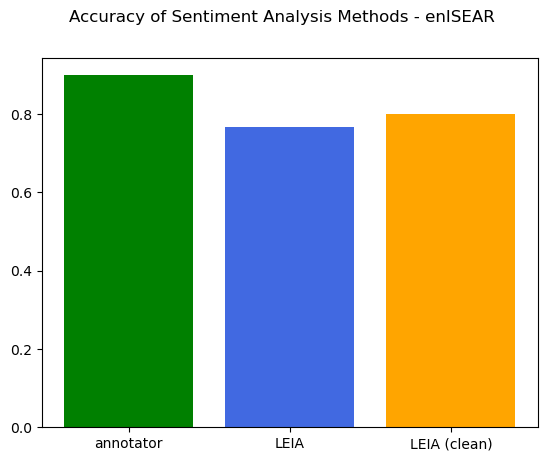

In [27]:
color_scheme = ['green', 'royalblue','orange']

annotator = accuracy(df, col_prediction='Annotator_Majority_Label', col_label='Prior_Emotion')
leia= accuracy(df, col_prediction='Leia_Label', col_label='Prior_Emotion')
leia_clean = accuracy(df, col_prediction='Leia_Label_Clean', col_label='Prior_Emotion')

labels = ['annotator', 'LEIA', 'LEIA (clean)']

plt.bar(labels, [annotator, leia, leia_clean], color=color_scheme)
plt.suptitle('Accuracy of Sentiment Analysis Methods - enISEAR');

Next calculate the precision of the `"Joy"` class for the data.
This is calculated as follows:
$
\begin{align}
    precision = \frac{TP}{TP + FP}
\end{align}
$
*Note: Here the Positive samples are the one with the the class `"Joy"`*

In [28]:
def precision(df, col_prediction, label, col_label='label'):
    df_selected = df[df[col_prediction] == label].reset_index(drop=True)
    tp = (df_selected[col_prediction] == df_selected[col_label]).sum()
    fp = len(df_selected) - tp
    return tp / (tp + fp)

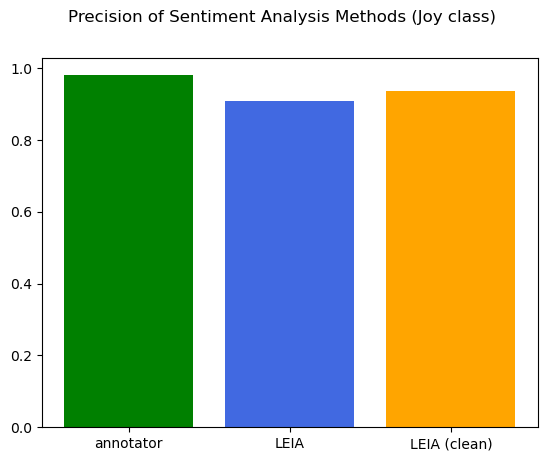

In [29]:
# calculate the precision for each model
annot_joy = precision(df, col_prediction='Annotator_Majority_Label',label='Joy', col_label='Prior_Emotion')
leia_joy = precision(df, col_prediction='Leia_Label',label='Joy', col_label='Prior_Emotion')
leia_clean_joy = precision(df, col_prediction='Leia_Label_Clean',label='Joy', col_label='Prior_Emotion')

# plot the results
plt.bar(labels, [annot_joy, leia_joy, leia_clean_joy], color=color_scheme)
plt.suptitle('Precision of Sentiment Analysis Methods (Joy class)');

Now calculate the recall score. This is done by:
$
\begin{align}
    recall = \frac{TP}{TP + FN}
\end{align}
$
*Note: Here the Positive samples are the one with the the class `"Joy"`*

In [30]:
# recall
def recall(df, col_prediction, label, col_label='label'):
    df_selected = df[df[col_label] == label].reset_index(drop=True)
    tp = (df_selected[col_prediction] == df_selected[col_label]).sum()
    fn = len(df_selected) - tp
    return tp / (tp + fn)

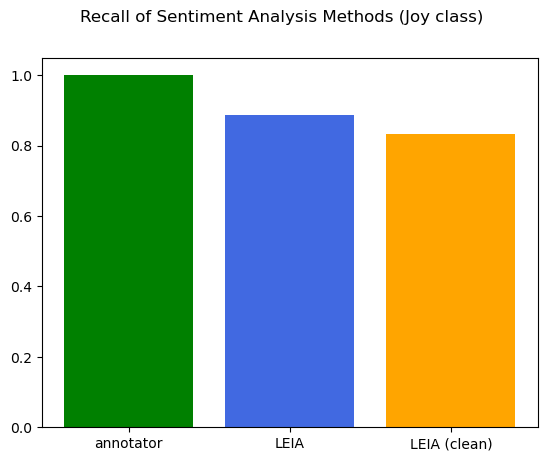

In [31]:
# tweet dataset
annot_joy = recall(df, col_prediction='Annotator_Majority_Label',label='Joy', col_label='Prior_Emotion')
leia_joy = recall(df, col_prediction='Leia_Label',label='Joy', col_label='Prior_Emotion')
leia_clean_joy = recall(df, col_prediction='Leia_Label_Clean',label='Joy', col_label='Prior_Emotion')

# plot the results
plt.bar(labels, [annot_joy, leia_joy, leia_clean_joy], color=color_scheme)
plt.suptitle('Recall of Sentiment Analysis Methods (Joy class)');

Last, calculate the [F1 score](https://towardsdatascience.com/the-f1-score-bec2bbc38aa6) of the joy class. The F1 score is calculated as:

$
\begin{align}
    F_1 = 2 * \frac{precision * recall}{precision + recall}
\end{align}
$

In [32]:
def f1_score(df, col_prediction, label, col_label='label'):
    prec = precision(df, col_prediction, label, col_label)
    rec = recall(df, col_prediction, label, col_label)
    
    return 2 * (prec * rec) / (prec + rec)

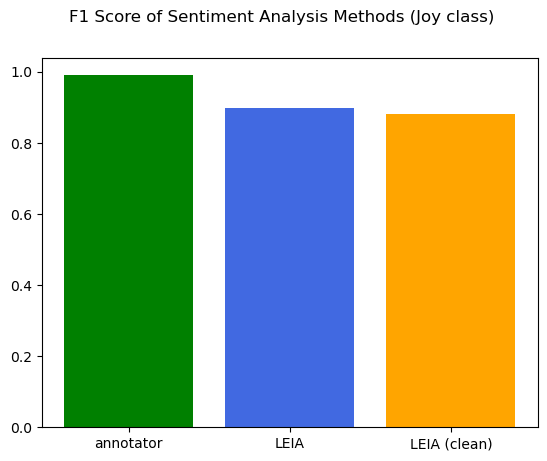

In [33]:
# calculate the F1 score of the joy class of each classifier 


# positive class
annot_joy = f1_score(df, col_prediction='Annotator_Majority_Label',label='Joy', col_label='Prior_Emotion')
leia_joy = f1_score(df, col_prediction='Leia_Label',label='Joy', col_label='Prior_Emotion')
leia_clean_joy = f1_score(df, col_prediction='Leia_Label_Clean',label='Joy', col_label='Prior_Emotion')

plt.bar(labels, [annot_joy, leia_joy, leia_clean_joy], color=color_scheme)
plt.suptitle('F1 Score of Sentiment Analysis Methods (Joy class)');



This can also be done for the other classes `'Sadness', 'Guilt', 'Anger', 'Disgust', 'Fear', 'Joy', 'Shame'`.

Now, try to calculate the mean f1 score over all classes for each of the classifiers.

In [34]:
#get all labels 
emots = df['Prior_Emotion'].unique()


annot_f1 = np.mean([f1_score(df, label=emot, col_prediction='Annotator_Majority_Label', col_label='Prior_Emotion')
                   for emot in emots])

print('Human majority f1: \033[1m{:.2%}\033[0m'.format(annot_f1))

leia_f1 = np.mean([f1_score(df, label=emot, col_prediction='Leia_Label', col_label='Prior_Emotion')
                   for emot in emots])
print('Leia f1: \033[1m{:.2%}\033[0m'.format(leia_f1))

leia_clean_f1 = np.mean([f1_score(df, label=emot, col_prediction='Leia_Label_Clean', col_label='Prior_Emotion')
                   for emot in emots])
print('Leia Clean f1: \033[1m{:.2%}\033[0m'.format(leia_clean_f1))

leia_masked_f1 = np.mean([f1_score(df, label=emot, col_prediction='Leia_Label_Masked', col_label='Prior_Emotion')
                   for emot in emots])

Human majority f1: 91.17%
Leia f1: 76.56%
Leia Clean f1: 80.25%


#### 1.5 Interpretation

* Discuss your results. 
* Are the models accurately predicting human emotions?
* Which approach seems to work better? Why?
* What kind of additional preprocessing could we perform to improve the model's predictions?

### Exercise 2

#### 2.1 Data annotation
* In the following exercise you will need to test emotion detection methods on data from [Vent](https://www.vent.co/), a website where users talk about their feelings. 
* On GitHub, in your `a03` folder you can find 3 files. First open `sample_for_labeling.csv`, and label each row according the emotion the sentence expresses. The possible classes are: 0 (Sadness), 1 (Affection), 2 (Fear), 3 (Happiness), 4 (Anger). ***Important: Make sure to upload the labeled data with your submission.***
* After you finished labeling the data load it as a pandas dataframe. Also load `sample_with_labels.csv` as a dataframe, which contains the actual labels of the data.
* Merge the two dataframes, and rename the column containing your labels as `label_human`.
* Rename the class ids (0, 1, 2, ...) stored in the `label`, and `label_human` columns to the class names (Sadness, Affection, ...).

In [35]:
# changes label to text
df = pd.read_csv('vent_random_split_20_per_label_revised_1.csv')
df['label'] = df['label'].replace(pipe_leia.model.config.id2label)

#### 2.2 LEIA
* Use the [LEIA](https://huggingface.co/LEIA/LEIA-base) model introduced in the previous exercise to classify the sentences and store the results in a column named `label_leia`.

In [36]:

df['LEIA_label'] = df['text'].progress_apply(lambda x: pipe_leia(x)[0]['label'])

  0%|          | 0/100 [00:00<?, ?it/s]

#### 2.3 Analysis
* Look at the performance of the the model, as well as the quality of your annotation using the metrics introduced in part 1 (accuracy, precision, recall) or other metrics you find interesting. Create informative visualizations to aid the comparison.
* Discuss your results. 
* Are the models accurately predicting human emotions?
* Which approach seems to work better? Why?

In [37]:

print('LEIA accuracy {:.2%}'.format(accuracy(df, col_prediction='LEIA_label', col_label='label')))

LEIA accuracy 73.00%


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

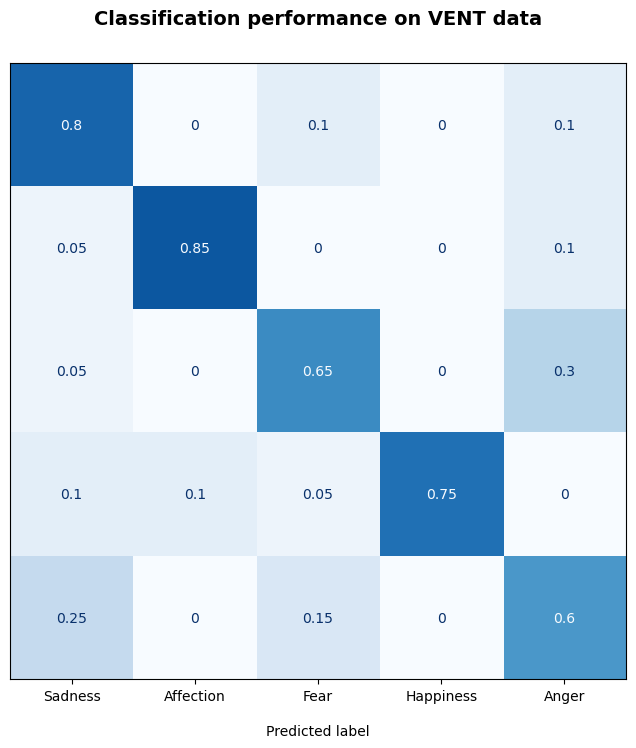

In [39]:

labels = df['label'].unique()


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 8))


ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
ax.set_title('Classification performance on VENT data', y=1.05, size=14, weight='bold')




cm_leia = confusion_matrix(y_true=df['label'], y_pred=df['LEIA_label'], normalize='true', labels=labels)
disp_leia = ConfusionMatrixDisplay(cm_leia, display_labels=labels)
disp_leia.plot(ax=ax, cmap='Blues')
ax.get_yaxis().set_visible(False)
disp_leia.im_.set_clim(0, 1)
disp_leia.im_.colorbar.remove();